# Simulation Code

In [15]:
import jax.numpy as np
import numpy as onp
from jax.lax import scan,cond
from jax import vmap,jit,random,grad
from functools import partial
from jax.scipy.stats.norm import pdf,cdf
from bisect import bisect_left as bl

from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams["text.usetex"] = True



### For Debugging

In [16]:

debug = False
if debug: # a non-accelerated version of jax.lax.scan for testing purposes
  def scan(f,c0,xs=None,length = 1):
    if xs is None:
      xs = [None]*length
    c = c0
    ys = []
    for x in xs:
      c,y = f(c,x)
      ys.append(y)
    ds = []
    try:
      _ = iter(ys[0])
      for i in range(len(ys[0])):
        d = []
        for j in range(len(ys)):
          d.append(ys[j][i])
        ds.append(np.array(d))
    except:
      ds = np.array(ys)
    return c,ds

### Free Energy Function

In [17]:
from scipy.interpolate import CubicSpline


FEdata = onp.load("protein_free_energy_data.npz",allow_pickle = True)
eps = onp.array(FEdata["epsilon"])
fes = onp.array(FEdata["free_energy"])
dfes = onp.array(FEdata["free_energy_der"])


i = np.where(fes == np.min(fes))[0][0]
x0 = eps[i]
print(x0)
print(fes[i])


N = 1400
FE = CubicSpline(eps[N:],fes[N:],bc_type = "not-a-knot",extrapolate=True)
dFE = CubicSpline(eps[N:],dfes[N:],bc_type = "not-a-knot",extrapolate = True)
de = eps[-1] - eps[0]




eps = np.linspace(eps[0] - 4*de ,eps[-1] + 4*de,15*len(eps))
fes = np.array(FE(eps))
dfes = np.array(dFE(eps))

h = 0.001
sk0 = (dFE(h) - dFE(-h))/2/h
x0 = 1.15698
sk1 = (dFE(x0 + h) - dFE(x0 - h))/2/h
print(sk0,sk1)


0.0
11.445217898732395
401672.61440449965 16352.562236641923


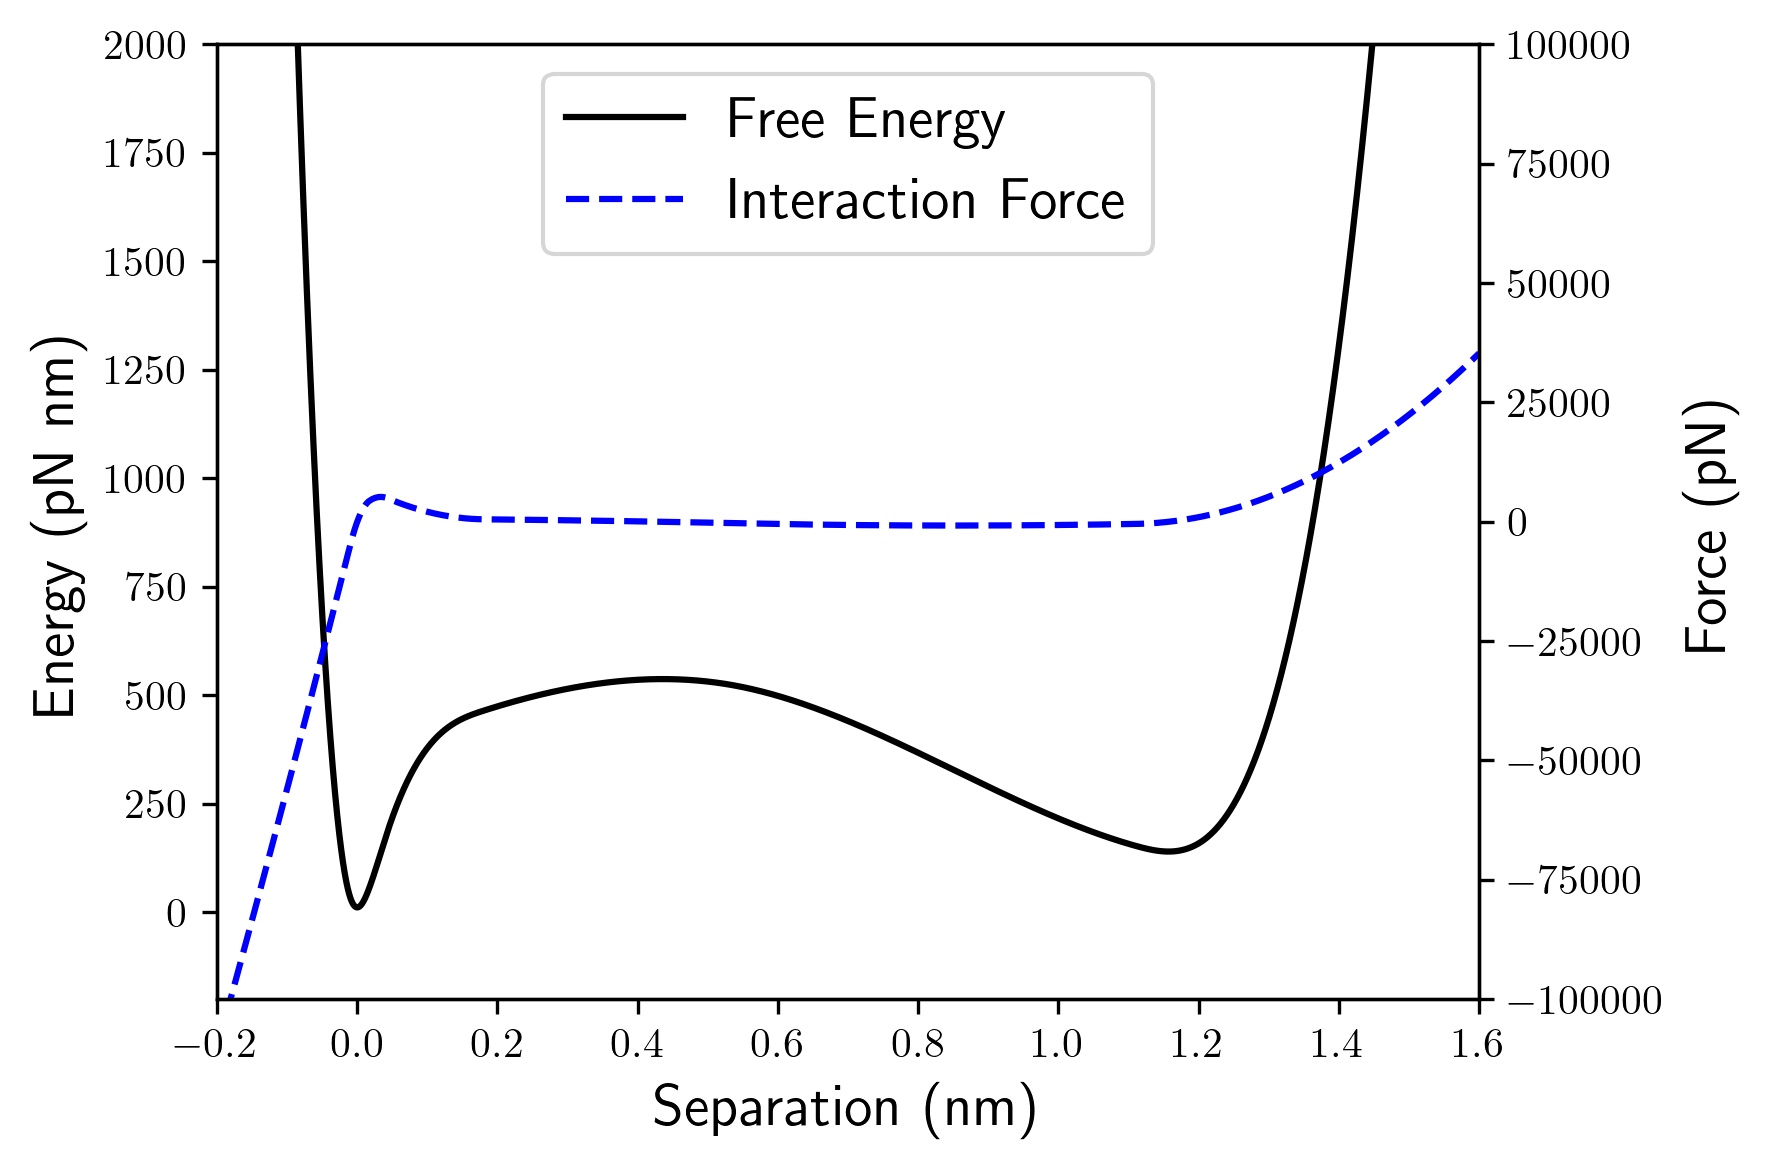

In [18]:
fig,ax = plt.subplots(1,1,figsize = (6,4),dpi = 300)
fs = 14
ax.plot(eps,fes,color = "black",linestyle = "solid")
tax = ax.twinx()

tax.plot(eps,dfes,color = "blue",linestyle = "dashed")
ax.set_xlim([-0.2,1.6])
ax.set_ylim([-2e2,2e3])
tax.set_ylim([-1e5,1e5])

blackLine = mlines.Line2D([],[],color = "k",label = "Free Energy")
blueLine = mlines.Line2D([],[],color = "b",label = "Interaction Force",linestyle = "dashed")

ax.legend(loc = "upper center",handles = [blackLine,blueLine],fontsize = fs)
ax.set_xlabel("Separation (nm)", fontsize = fs)
ax.set_ylabel("Energy (pN nm)",fontsize = fs)
tax.set_ylabel("Force (pN)",fontsize = fs)

plt.tight_layout()
plt.savefig("Fig4.pdf")
plt.show()

## Simulation Classes

### Support functions

In [19]:

def ker(x):
  return np.exp(-x@x/2)*((2*np.pi)**(-len(x)/2))

def logker(x,h):
  return -x@x/2/h**2 - len(x)/2*np.log(2*np.pi*h**2)


@jit
def eval_kde(y,xs,h):
  logkers = vmap(logker,in_axes = (0,None))(y-xs,h)
  pref = np.max(logkers)
  logkers = logkers - pref
  return np.exp(pref)*np.mean(np.exp(logkers))

@jit
def logpdf(y,xs,h):
  logkers = vmap(logker,in_axes = (0,None))(y-xs,h)
  pref = np.max(logkers)
  logkers = logkers - pref
  return pref + np.log(np.mean(np.exp(logkers)))

@jit
def logl(ys,xs,h):
  def sf(s,y):
    s = s + logpdf(y,xs,h)
    return s,None
  S,_ = scan(sf,0.,ys)
  return S

@jit #Flag, JAX may not like this!
def dxkde(y,xs,h):
  def sf(s,z):
    s = s - z*ker(z)
    return s,None
  S,_ = scan(sf,np.zeros(len(y)),(y-xs)/h)
  return S/len(xs)/h**(len(y)+1)

@jit
def entaprx(ys,xs,h,lyCut):
  def sf(s,y):
    l = logpdf(y,xs,h)
    l = cond(np.isinf(l),lambda x: 0.,lambda x: l,None)
    s += l*(1 + np.sign(l-lyCut))/2
    return s,None
  S,_ = scan(sf,0.,ys)
  return -S/len(ys)

@partial(jit,static_argnums = (5,))
def opt(h,xmle,xkde,dh0,scale = 1/np.sqrt(2),nSteps = 100):
  def sc(c,n):
    h,v,dh = c
    vp = logl(xmle,xkde,h+dh)
    vm = logl(xmle,xkde,h-dh)
    nh,nv = cond(v < vp,lambda x: (h+dh,vp),lambda x: (h,v),None)
    nh,nv = cond(nv < vm,lambda x: (h-dh,vm),lambda x: (nh,nv),None)
    dh = cond(v == nv,lambda x: dh*scale,lambda x: dh,None)
    return (nh,nv,dh),None
  c,_ = scan(sc,(h,logl(xmle,xkde,h),dh0),None,length = nSteps)
  h,_,dh = c
  return h,dh

def indc(x):
  return 1/2*(1 + np.sign(x))

@jit
def bDiff(x):
  x = x.at[1:].set(x[1:]-x[:-1])
  return x

@jit
def fDiff(x):
  x = x.at[:-1].set(x[1:]-x[:-1])
  x = x.at[-1].set(-x[-1])
  return x

@jit
def diff2(x):
  x0 = x[0]
  x = bDiff(fDiff(x))
  x = x.at[0].set(x[0] - x0)
  return x


@partial(jit,static_argnums = (0,))
def rk4Step(f,x,y,t,dt):
  kx1,ky1 = f(x,y,t)
  kx2,ky2 = f(x + kx1*dt/2,y + ky1*dt/2,t + dt/2)
  kx3,ky3 = f(x + kx2*dt/2,y + ky2*dt/2,t + dt/2)
  kx4,ky4 = f(x + kx3*dt,y + ky3*dt,t + dt)
  return x + dt/6 *(kx1 + 2*kx2 + 2*kx3 + kx4),y + dt/6 *(ky1 + 2*ky2 + 2*ky3 + ky4)




### Langevin Dynamics

In [20]:

class Langevin:
  def __init__(self,eps,fes,dfes,param0 = {"eta":1.,"beta":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    self.eps = eps
    self.fes = fes
    self.dfes = dfes
    return

  def v(self,x):
    return np.interp(x,self.eps,self.fes,left = 0.,right = 0.)

  def f(self,x): #pairwise interaction force
    return np.interp(x,self.eps,self.dfes,left = 0.,right =0.)

  def V(self,x,t):
    augx = np.zeros(x.shape[0]+2)
    augx = augx.at[1:-1].set(x)
    augx = augx.at[-1].set(self.ell(t))
    dx = augx[1:] - augx[:-1]
    return np.sum(vmap(self.v)(dx))

  def F(self,x,t):
    augx = np.zeros(x.shape[0]+2)
    augx = augx.at[1:-1].set(x)
    augx = augx.at[-1].set(self.ell(t))
    dx = augx[1:] - augx[:-1]
    Fs = vmap(self.f)(dx)
    return Fs[1:] - Fs[:-1]

  def fEx(self,x,t):
    return self.f(self.ell(t) - x[-1])

  def dx(self,key,xs,t,dt):
    f = vmap(self.F,in_axes = (0,None))(xs,t)
    key,k1 = random.split(key)
    bm = random.normal(k1,xs.shape)
    return key,f*dt/self.eta + np.sqrt(2*dt/self.eta/self.beta)*bm

  def dW(self,xs,t,dt):
    fex = vmap(self.fEx,in_axes = (0,None))(xs,t)
    return fex*grad(self.ell)(t)*dt


  @partial(jit,static_argnums = (0,6))
  def run(self,key,x0s,t0,W0,dt,nSteps):
    def func(carry,n):
      k0,x,t,W = carry
      k0,dx = self.dx(k0,x,t,dt)
      dW = self.dW(x,t,dt)
      carry = k0,x+dx,t+dt,W+dW
      return carry,None
    c0 = key,x0s,t0,W0
    out,_ = scan(func,c0,None,length = nSteps)
    key,x1,t1,W1 = out
    return key,x1,t1,W1

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,key,x0s,t0,W0,dt,nSteps,nLeap):
    def sf(c,n):
      key,x,t,W = c
      c = self.run(key,x,t,W,dt,nLeap)
      return c,c
    c0 = key,x0s,t0,W0
    _,out = scan(sf,c0,None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,))
  def entropy(self,xmle,xkde,xeval,h0):
    h,_ = opt(h0,xmle,xkde,0.05,nSteps = 10)
    return entaprx(xeval,xkde,h,-np.log(len(xkde))/np.log(10)*3)

  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,xmles,xkdes,xevals,ts,Ws,h0=0.2):
    xs = np.concatenate((xmles,xkdes,xevals),axis = 1)
    dt = ts[1] - ts[0]
    Vs = np.mean(vmap(vmap(self.V,in_axes = (0,None)),in_axes = (0,0))(xs,ts),axis = -1)
    Ws = np.mean(Ws,axis = -1)
    Vs = Vs.at[1:].set(Vs[1:] - Vs[:-1])/dt
    Ws = Ws.at[1:].set(Ws[1:] - Ws[:-1])/dt
    def sf(n,i):
      out = self.entropy(xmles[i],xkdes[i],xevals[i],h0)
      return None,out
    _,ents = scan(sf,None,np.arange(xmles.shape[0]))
    ents = ents.at[1:].set(ents[1:] - ents[:-1])/self.beta
    return (Ws - Vs),ents


  def phases(self,xs,ts):
    # ts,nSamps,dim
    augxs = np.zeros((xs.shape[0],xs.shape[1],xs.shape[2]+2))
    augxs = augxs.at[:,:,1:-1].set(xs)
    augxs = augxs.at[:,:,-1].set((np.ones((xs.shape[1],xs.shape[0]))*self.ell(ts)).T)
    dx = augxs[:,:,1:] - augxs[:,:,:-1]
    return np.sum(dx > 0.,axis = 1)/dx.shape[1]

  def getFrontLoc(self,xs,ts):
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)

### STIV with Gauss-Hermite Integration

In [21]:
class STIVgh: # This is going to be a quartic example
  def __init__(self,eps,fes,dfes,param0 = {"beta":1.,"eta":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    self.eps = eps
    self.fes = fes
    self.dfes = dfes
    return

  def du(self,x):
    return np.interp(x,self.eps,self.dfes,left = 0.,right = 0.)

  def F(self,m,s):
    ws = np.array([5.079294790166e-1,
        2.806474585285e-1,
        8.381004139899e-2,
        1.288031153551e-2,
        9.322840086242e-4,
        2.711860092538e-5,
        2.320980844865e-7,
        2.654807474011e-10])
    xs = np.array([0.27348104613815,
        0.82295144914466,
        1.38025853919888,
        1.95178799091625,
        2.54620215784748,
        3.17699916197996,
        3.86944790486012,
        4.68873893930582])
    ws = np.concatenate((ws[::-1],ws))
    xs = np.concatenate((-xs[::-1],xs))
    return np.sum(-self.du(np.sqrt(2)*s*xs + m)*ws)/np.sqrt(np.pi)

  def dFdm(self,m,s):
    h = 0.001
    fm2 = self.F(m-2*h,s)
    fm1 = self.F(m-h,s)
    f1 = self.F(m+h,s)
    f2 = self.F(m+2*h,s)
    return (fm2/12 - 2/3*fm1 + 2/3*f1 - f2/12)/h


  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    eps = np.zeros(mu.shape[0] + 2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    muDot = 1/self.eta*(vmap(self.F,in_axes = (0,0))(eps[:-1],tau[:-1])
                        - vmap(self.F,in_axes = (0,0))(eps[1:],tau[1:]))
    sDot = s/self.eta*(vmap(self.dFdm,in_axes = (0,0))(eps[:-1],tau[:-1])
                        + vmap(self.dFdm,in_axes = (0,0))(eps[1:],tau[1:]) + 1/self.beta/s**2)
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    def sf(c,n):
      mu,s,t = c
      c = self.step(mu,s,t,dt)
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  def fEx(self,mu,s,t):
    return -self.F(self.ell(t) - mu[-1],s[-1])

  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,mu,s,t):
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot @ muDot + sDot @ sDot)


  def phase(self,mu,s,t):
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts):
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)


### STIV with sampling

In [22]:
class STIVSampling: # This is going to be a quartic example
  def __init__(self,eps,fes,dfes,param0 = {"eta":1.,"beta":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    self.f = np.zeros((1,1)) # Store the coeffs for an approximate free energy
    self.eps = eps
    self.fes = fes
    self.dfes = dfes
    return

  def u(self,x):
    return np.interp(x,self.eps,self.fes,left = 0.,right = 0.)

  def du(self,x):
    return np.interp(x,self.eps,self.dfes,left = 0.,right = 0.)


  def makeAprxF(self,key,muBound,sBound,ChevOrder,muOrder,sOrder,nSamples):
    # this function will construct the self.C to be used in future approximations
    muChev = (muBound[1] - muBound[0])/2 * (np.cos(np.pi * np.arange(1,ChevOrder + 2)/(ChevOrder + 2))[::-1] + 1) + muBound[0]
    sChev = (sBound[1] - sBound[0])/2 * (np.cos(np.pi * np.arange(1,ChevOrder + 1)/(ChevOrder + 1))[::-1] + 1) + sBound[0]
    M,S = np.meshgrid(muChev,sChev)
    FS = -np.mean(self.du(random.normal(key,shape = (nSamples,M.shape[0],M.shape[1]))*S + M),axis = 0)
    M = (np.ones((muOrder + 1,ChevOrder + 1))*muChev).T **(np.arange(muOrder + 1))
    S = (np.ones((sOrder  + 1,ChevOrder    ))*sChev).T **(np.arange(sOrder + 1))
    A,x,Bt = np.linalg.svd(M,full_matrices = False)
    M = Bt.conj().T @ np.diag(1/x) @ A.conj().T
    A,x,Bt = np.linalg.svd(S,full_matrices = False)
    S = Bt.conj().T @ np.diag(1/x) @ A.conj().T
    self.f = M @ FS.T @ S.T
    return self.f

  @partial(jit,static_argnums = (0,))
  def F(self,f,m,s):
    return (m**np.arange(f.shape[0])) @ f @ (s**np.arange(f.shape[1]))

  def checkConsistency(self,mus,ss,ts,muBound,sBound):
    fig,ax = plt.subplots(1,1,figsize = (16,9))
    mPnts = np.linspace(muBound[0],muBound[1],100)
    sPnts = np.linspace(sBound[0],sBound[1],100)
    M,S = np.meshgrid(mPnts,sPnts)
    FS = (vmap(self.F,in_axes = (None,0,0))(self.f,M.flatten(),S.flatten())).reshape(M.shape)
    ax.contourf(M,S,FS,cmap = "terrain",levels = 50)

    eps = np.zeros((mus.shape[0],mus.shape[1] + 2))
    eps = eps.at[:,1:-1].set(mus)
    eps = eps.at[:,-1].set(self.ell(ts))
    eps = eps[:,1:] - eps[:,:-1]
    tau = np.zeros((ss.shape[0],ss.shape[1] + 2))
    tau = tau.at[:,1:-1].set(ss**2)
    tau = np.sqrt(tau[:,1:] + tau[:,:-1])

    ax.scatter(eps.flatten(),tau.flatten(),marker = "x",color = "r")  
    plt.show()
    plt.close(fig)
    return
    
  @partial(jit,static_argnums =(0,))
  def dFdm(self,f,m,s):
    return (np.arange(1,f.shape[0])*m**(np.arange(f.shape[0]-1))) @ f[1:,:] @ (s**np.arange(f.shape[1]))

  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    eps = np.zeros(mu.shape[0] + 2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    muDot = 1/self.eta*(vmap(self.F,in_axes = (None,0,0))(self.f,eps[:-1],tau[:-1])
                        - vmap(self.F,in_axes = (None,0,0))(self.f,eps[1:],tau[1:]))
    sDot = s/self.eta*(vmap(self.dFdm,in_axes = (None,0,0))(self.f,eps[:-1],tau[:-1])
                        + vmap(self.dFdm,in_axes = (None,0,0))(self.f,eps[1:],tau[1:]) + 1/self.beta/s**2)
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    def sf(c,n):
      mu,s,t = c
      c = self.step(mu,s,t,dt)
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out


  def fEx(self,mu,s,t):
    return -self.F(self.f,self.ell(t) - mu[-1],s[-1])


  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,mu,s,t):
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot @ muDot + sDot @ sDot)

  def phase(self,mu,s,t):
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts):
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)


## Simulations

### Parameters

Total Sim Steps 2e+04
Time step 0.01
Relaxation Times 0.728 17.9
Total time: 200.000
Output dt: 0.10000
Final Extension: 20.000


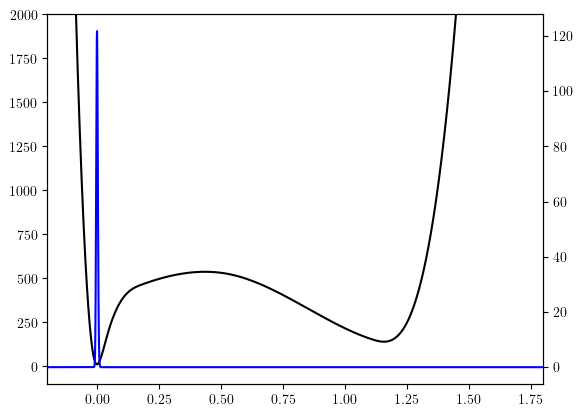

In [23]:
visWat = 8.53e-4 # Ns/m^2
eta = 100000*2*np.pi *visWat/(np.log(10) -.47) * 1e3 # convert from Ns/m^2 to pN ns/nm^2 
# eta ~ 2.9246
beta = 1/(4.114*310/298) # kT = 4.114 pN nm @ 298 K
#beta = .1
#eta = 1.
param = {"beta":beta,"eta":eta}
#param = {"beta":10.,"eta": 1.} # 1/pN nm ,
nMasses = 8
#u = 1/100
u = 1/10
ell_func = lambda t: u*t
ell_func0 = lambda t: np.zeros_like(t)
key = random.PRNGKey(247729)

fname = "realisticLarge"

# Langevin parameters
nSim = 10000
nMLE = 200#int(min(nSim*.1,200))
nKDE = 4900#int((nSim - nMLE)/2)

x0 = np.zeros((nSim,nMasses))
x0 = x0.at[:,-1].set(np.ones(nSim)*1.25)
W0 = np.zeros((nSim,))



# mostly uncoiled at ell = 12 for 9 bonds

# STIV Simulation parameters
t0 = 0.0
dt = 10000e-6 # 2e-6   Simulations will take 24 at full run parameters
nStep = 2000 #2e3 # 2e3
nEvery = 10 # 3e4

print("Total Sim Steps %0.1g"%(nStep*nEvery))
print("Time step %0.3g" %(dt))
print("Relaxation Times %0.3g %0.3g"%(eta/sk0,eta/sk1))
print("Total time: %0.3f" %(dt*nStep*nEvery))
print("Output dt: %0.5f" %(dt*nEvery))
print("Final Extension: %0.3f" %(dt*nStep*nEvery*u))

# STIVsampling
muBound = [-.1,2.5]
sBound = [0.,0.02]
ChevOrder = 25
muOrder = 9
sOrder = 9
nSamples = 500000




pltxs = eps
pltys = fes
ps = np.exp(-beta*pltys)
ps = ps/np.sum(ps)/(eps[1] - eps[0])


fig,ax = plt.subplots(1,1)
ax.plot(pltxs,pltys,color = "black")
tax = ax.twinx()
tax.plot(pltxs,ps,color = "blue")
ax.set_xlim([-.2,1.8])
ax.set_ylim([-1e2,2e3])
plt.show()




### Loading simulation classes

In [24]:
lSim0 = Langevin(eps,fes,dfes,param = param,ell = ell_func0,nMasses = nMasses)
lSim = Langevin(eps,fes,dfes,param = param,ell = ell_func,nMasses = nMasses)
ghESim = STIVgh(eps,fes,dfes,param = param,ell = ell_func,nMasses = nMasses)
sampleESim = STIVSampling(eps,fes,dfes,param = param,ell = ell_func,nMasses = nMasses)

print(lSim.beta,lSim.eta)
print(ghESim.beta,ghESim.eta)

0.23366318001474118 292458.83792865707
0.23366318001474118 292458.83792865707


## Running simulations

Initializing Langevin
Took:  16.210596799850464
Running Langevin
Took:  318.0050115585327
Langevin fEx
Took:  2.004967451095581
Langevin Entropy Production
Took:  1942.3134362697601
STIV Gauss-Hermite
Took:  14.75116515159607
Initializing STIV Sampling
Took:  33.5430326461792
Running STIV Sampler
Took:  2.3099968433380127


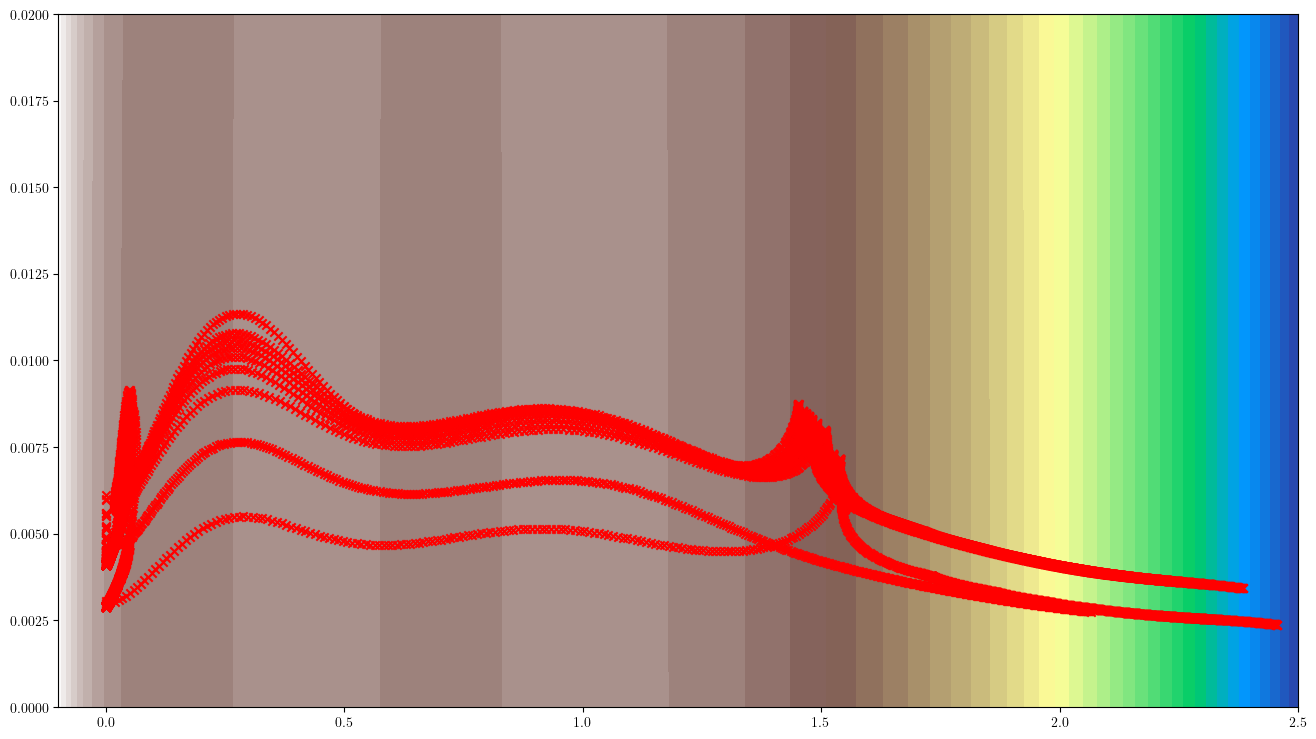

Done


In [25]:
import timeit
#fname = "realistic"
runLangevin = True
runSTIVgh = True
runSTIVsample = True

from time import time

print("Initializing Langevin")
time0 = time()
key,xs,_,_ =  lSim0.run(key,x0,t0,W0,dt,1000)
print("Took: ",time() - time0)
xInit = xs
mu0 = np.mean(xInit,axis = 0)
s0 = np.sqrt(np.diag(np.cov(xInit.T)))


if runLangevin:
  key,k0 = random.split(key)
  print("Running Langevin")
  time0 = time()
  #%timeit lSim.runCollect(k0,xInit,t0,W0,dt,nStep,nEvery)
  _,xs,ts,Ws = lSim.runCollect(k0,xInit,t0,W0,dt,nStep,nEvery)
  print("Took: ",time() - time0)
  print("Langevin fEx")
  time0 = time()
  fExL = vmap(vmap(lSim.fEx,in_axes = (0,None)))(xs,ts)
  print("Took: ",time() - time0)
  print("Langevin Entropy Production")
  time0 = time()
  e1,e2 = lSim.entropyProduction(xs[:,:nMLE],xs[:,nMLE:nMLE + nKDE],xs[:,nMLE+nKDE:],ts,Ws,h0=0.2)
  print("Took: ",time() - time0)
  entL = e1 + e2
  np.savez(fname + "LangevinData.npz",xInit = xInit,xs = xs,ts = ts,Ws=Ws,fExL = fExL,entL = entL)
else:
  lData = onp.load(fname + "LangevinData.npz",allow_pickle = True)
  xInit = np.array(lData["xInit"])
  xs = np.array(lData["xs"])
  ts = np.array(lData["ts"])
  Ws = np.array(lData["Ws"])
  fExL = np.array(lData["fExL"])
  entL = np.array(lData["entL"])



if runSTIVgh:
  print("STIV Gauss-Hermite")
  time0 = time()
  musG,ssG,etsG = ghESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)
  fExG = vmap(ghESim.fEx)(musG,ssG,etsG)
  entG = vmap(ghESim.entropyProduction)(musG,ssG,etsG)
  print("Took: ",time() - time0)
  np.savez(fname + "STIVghData.npz",musG = musG,ssG = ssG,etsG= etsG,fExG = fExG,entG = entG)
else:
  d = onp.load(fname + "STIVghData.npz",allow_pickle = True)
  musG = np.array(d["musG"])
  ssG = np.array(d["ssG"])
  etsG = np.array(d["etsG"])
  fExG = np.array(d["fExG"])
  entG = np.array(d["entG"])


if runSTIVsample:
  print("Initializing STIV Sampling")
  time0 = time()
  key,k0 = random.split(key)
  _ = sampleESim.makeAprxF(k0,muBound,sBound,ChevOrder,muOrder,sOrder,nSamples)
  print("Took: ",time() - time0)
  print("Running STIV Sampler")
  time0 = time()
  musS,ssS,etsS = sampleESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)   
  fExS = vmap(sampleESim.fEx)(musS,ssS,etsS)
  entS = vmap(sampleESim.entropyProduction)(musS,ssS,etsS)
  print("Took: ",time() - time0)
  np.savez(fname + "STIVsampleData.npz",musS = musS,ssS = ssS,etsS= etsS,fExS = fExS,entS = entS)
  sampleESim.checkConsistency(musS,ssS,etsS,muBound,sBound)
else:
  d = onp.load(fname + "STIVsampleData.npz",allow_pickle = True)
  musS = np.array(d["musS"])
  ssS = np.array(d["ssS"])
  etsS = np.array(d["etsS"])
  fExS = np.array(d["fExS"])
  entS = np.array(d["entS"])
print("Done")
np.savez(fname + "FullProteinSimulationData.npz",xInit=xInit,xs=xs,
         ts=ts,Ws=Ws,
         musG=musG,ssG=ssG,etsG=etsG,
         musS=musS,ssS = ssS,etsS=etsS,
         fExL = fExL,fExG = fExG,fExS = fExS,
         entL = entL,entG = entG,entS = entS)

# Analysis

### Load Data

In [26]:
import matplotlib.pyplot as plt

#fname = "testingV1_10" 
#fname = "realistic"
#fname = "test"


data = np.load(fname + "FullProteinSimulationData.npz",allow_pickle = True)
xInit = data["xInit"]
xs = data["xs"]
ts = data["ts"]
Ws = data["Ws"]
musG = data["musG"]
ssG = data["ssG"]
etsG = data["etsG"]
musS = data["musS"]
ssS = data["ssS"]
etsS = data["etsS"]
fExL = data["fExL"]
fExG = data["fExG"]
fExS = data["fExS"]
entL = data["entL"]
entG = data["entG"]
entS = data["entS"]



mxs = np.mean(xs,axis = 1)
sxs = np.std(xs,axis = 1)

allms = [mxs,musG,musS]
allss = [sxs,ssG,ssS]
allts = [ts,etsG,etsS]
allfExs = [np.mean(fExL,axis = 1),fExG,fExS]
allents = [entL,entG,entS]
print(xs.shape)

(2000, 10000, 8)


### Plot parameters

In [27]:
lCol = "red"
gCol = "blue"
sCol =  "deepskyblue"
lSty = (3,(5,5))
gSty = (8,(5,5))
sSty = (1,(2,3))
fs = 14
fsTick = 10
lLab = "Langevin"
gLab = "STIV Gauss-Hermite"
sLab = "STIV Sampling"
colors = [lCol,gCol,sCol]
styles = [lSty,gSty,sSty]
labels = [lLab,gLab,sLab]
sims = [lSim,ghESim,sampleESim]


### Plotting Strain

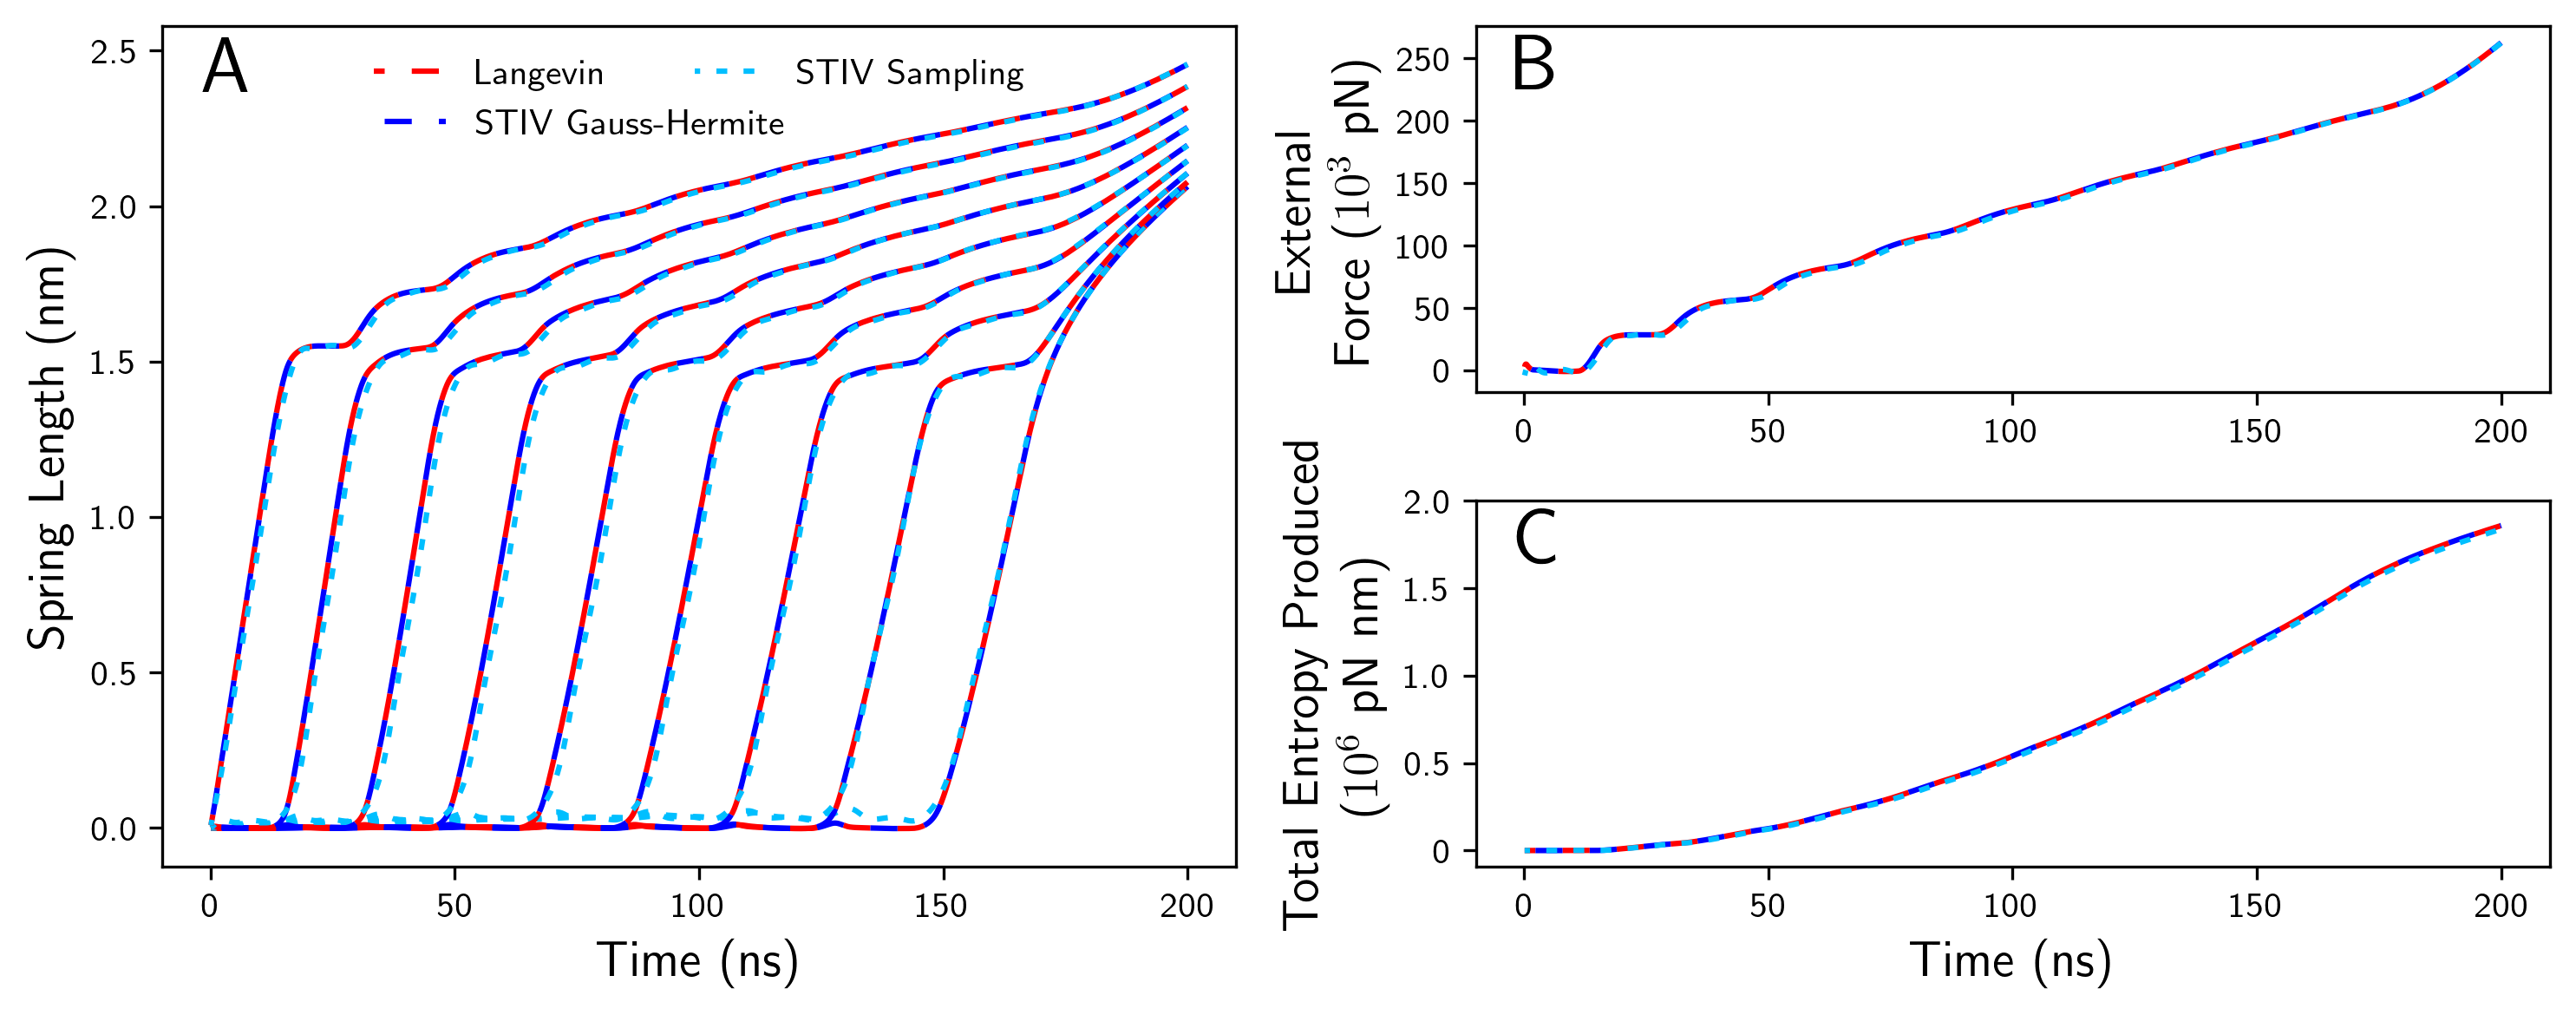

In [28]:
def diff(m,l):
  em = np.zeros(m.shape[0]+2)
  em = em.at[1:-1].set(m)
  em = em.at[-1].set(l)
  return em[1:] - em[:-1]

alldms = [vmap(diff)(allms[i],sims[i].ell(allts[i])) for i in range(len(sims))]

fig = plt.figure(figsize = (10,4),dpi = 300)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,4)
ax = [ax1,ax2,ax3]
#fig,ax = plt.subplots(1,3,figsize = (12,4),dpi = 300)
for i in range(alldms[0].shape[-1]):
    for j in range(len(sims)):
      if i ==0:
        ax[0].plot(allts[j],alldms[j][:,i],color = colors[j],linestyle = styles[j],label = labels[j])
      else:
        ax[0].plot(allts[j],alldms[j][:,i],color = colors[j],linestyle = styles[j])
for j in range(len(sims)):
  ax[1].plot(allts[j],allfExs[j],color = colors[j],linestyle = styles[j],label = labels[j])
  ax[2].plot(allts[j],(allts[j][1] - allts[j][0])*(np.cumsum(allents[j]) - allents[j][0]),color = colors[j],linestyle = styles[j],label = labels[j])
ax[0].legend(loc = "upper center",fontsize=  fs-4,frameon = False,ncols = 2,columnspacing = -2.5)
ax[0].set_xlabel("Time (ns)",fontsize = fs)
ax[2].set_xlabel("Time (ns)",fontsize = fs)
ax[0].set_ylabel("Spring Length (nm)",fontsize = fs)
ax[0].set_xticks([0,50,100,150,200],labels = [0,50,100,150,200],fontsize = fsTick)
ax[0].set_yticks([0.0,0.5,1.0,1.5,2.0,2.5],labels = [0.0,0.5,1.0,1.5,2.0,2.5], fontsize = fsTick)
ax[1].set_ylabel("External\nForce " + r"($10^3$ pN)", fontsize = fs)
ax[1].set_xticks([0,50,100,150,200],labels = [0,50,100,150,200],fontsize = fsTick)
#ax[1].set_yticks([0,5e4,10e4,15e4,20e4,25e4])
ax[1].set_yticks([0,5e4,10e4,15e4,20e4,25e4],labels = [0,50,100,150,200,250],fontsize = fsTick)
ax[2].set_ylabel("Total Entropy Produced\n" r"($10^6$ pN nm)",fontsize = fs)
ax[2].set_xticks([0,50,100,150,200],labels = [0,50,100,150,200],fontsize = fsTick)
#ax[2].set_yticks([0,5e5,10e5,15e5,20e5])
ax[2].set_yticks([0,5e5,10e5,15e5,20e5],labels = [0,.5,1.0,1.5,2.0],fontsize = fsTick)
#ax[0].set_title("Spring Lengths",fontsize = fs)
#ax[1].set_title("External Force",fontsize = fs)
#ax[2].set_title("Total Entropy Produced",fontsize = fs)
#ax[0].ticklabel_format(axis = "y",style = "sci", scilimits = (4,4))
ax[0].text(0.06,0.945,"A",fontsize = fs+8,ha = "center",va = "center",transform = ax[0].transAxes)
ax[1].text(0.06,0.88,"B",fontsize = fs+8,ha = "center",va = "center",transform = ax[1].transAxes)
ax[2].text(0.06,0.88,"C",fontsize = fs+8,ha = "center",va = "center",transform = ax[2].transAxes)
plt.tight_layout()
plt.savefig("Fig5.pdf")
plt.show()